# SETUP
***

Tópico destinado a configuração do notebook (importação das bibliotecas, criação de função, configuração de gráficos) e leitura inicial dos dados. 

## Bibliotecas

In [118]:
# Dados

import pandas as pd
import numpy as np 

# DataViz

import matplotlib.pyplot as plt 
import seaborn as sns
from ipywidgets import interact

# Estatística

from scipy.stats import normaltest

# Outros

import warnings

In [74]:
warnings.filterwarnings("ignore")

## Funções

## Configurações de Gráficos

In [ ]:
sns.set_palette("Accent")
sns.set_style("darkgrid")

## Leitura dos dados

In [75]:
df = pd.read_csv('/home/mateus/Downloads/estudo_de_caso_-_análise_de_dados_de_crédito/customer_database_case_study.csv')

# Entendimento de negócio
***

De acordo com a solicitação do time de crédito, esse estudo tem os seguintes objetivos:


1) Entender se a política de crédito atual tem relação com o comportamento final do cliente, se está impedindo de clientes com probabilidade de inadimplência receba o crédito (Teste de Hipóteses)

2) Compreender quais principais variáveis impactam na variação do score. (regressão)

3) Treinar um algorítimo de classificação capaz de prever os clientes que ainda não possuem a variável target (inadimplência) definida. (regressão logística)

# Entendimento dos Dados

colocar um resumo dos dados e quais tratamentos vão precisar ser aplicados

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        10000 non-null  int64  
 1   ApplicationDate   10000 non-null  object 
 2   CreditAmount      10000 non-null  int64  
 3   PersonType        10000 non-null  object 
 4   ApprovalStatus    10000 non-null  object 
 5   ProductType       10000 non-null  object 
 6   City              9486 non-null   object 
 7   PersonIncome      4688 non-null   float64
 8   PersonAge         4703 non-null   float64
 9   CompanyRevenue    4800 non-null   float64
 10  CompanyAge        4817 non-null   float64
 11  EconomicActivity  4796 non-null   object 
 12  CreditScore       10000 non-null  int64  
 13  DefaultStatus     4954 non-null   float64
dtypes: float64(5), int64(3), object(6)
memory usage: 1.1+ MB


A coluna Id será removida já que não terá utilidade para análise. Após isso será realizado alguns processos de limpeza e engenharia no dataset, a fim de otimizar para as análises.

# Tratamento dos dados
***

Tópico destinado ao tratamento de dados (verificação de nulos, zeros, outliers).

Tratar engenharia das colunas (criar coluna unificada de idade, renda), transformar o pedido de credito em dias (em relação a data atual), limpar nulos, zeros, duplicados, outliers. 

Notei que o Dataset apresenta uma organização do tipo wide format, a fim de otimizar o dataframe para análise e modelagem irei organizar o Dataset em long format, unificando as colunas de Idade e Renda PF e PJ.

In [77]:
df_pj = df[df['PersonType'] == 'PJ'][['CustomerID','ApplicationDate','CreditAmount','PersonType','ApprovalStatus','ProductType','City','CompanyRevenue','CompanyAge','EconomicActivity','CreditScore','DefaultStatus']]
df_pj.rename(columns={'CompanyAge':'Age','CompanyRevenue':'Revenue'}, inplace=True)
df_pf = df[df['PersonType'] == 'PF'][['CustomerID','ApplicationDate','CreditAmount','PersonType','ApprovalStatus','ProductType','City','PersonIncome','PersonAge','EconomicActivity','CreditScore','DefaultStatus']]
df_pf.rename(columns={'PersonAge':'Age','PersonIncome':'Revenue'}, inplace=True)
df = pd.concat([df_pj,df_pf], axis=0)

O próximo tratamento que irei realizar é transformar a data da tomada de crédito em dias até o dia de hoje (20/08/2024), para criar uma nova variável que pode ser útil pra identificar padrões.

In [78]:
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], format='%Y-%m-%d')
df['ApplicationDate'] = (pd.Timestamp.today() - df['ApplicationDate']).dt.days

## Nulos, Duplicados, Zeros
***

Agora será verificado a presença de nulos, zeros desnecessários e dados duplicados, e seguir com o processo de limpeza. Para esse processo primeiramente irei verificar quais colunas possuem dados nulos em excesso, depois explorar alguns dados descritivos das variáveis, além de plotar a distribuição dos dados para compreender qual o tratamento mais adequado.

In [79]:
nulos = pd.DataFrame(data=[df.isnull().sum(),(df.isnull().sum() / len(df)) * 100]).T
nulos.columns = ['Absoluto', 'Percentual']
nulos

,Absoluto,Percentual
CustomerID,0.0,0.00
ApplicationDate,0.0,0.00
CreditAmount,0.0,0.00
PersonType,0.0,0.00
ApprovalStatus,0.0,0.00
ProductType,0.0,0.00
City,514.0,5.14
Revenue,512.0,5.12
Age,480.0,4.80
EconomicActivity,5204.0,52.04


In [80]:
df.describe()

,CustomerID,ApplicationDate,CreditAmount,Revenue,Age,CreditScore,DefaultStatus
count,10000.000000,10000.00000,10000.000000,9.488000e+03,9520.000000,10000.000000,4954.000000
mean,250905.367100,415.41290,4887.491600,2.740978e+05,26.689601,574.973600,0.185305
std,142490.098449,104.72097,4872.023048,4.102435e+05,21.354387,182.168159,0.388584
min,49.000000,234.00000,0.000000,3.490000e+02,0.000000,200.000000,0.000000
25%,128342.000000,326.00000,1414.000000,3.050825e+04,7.000000,446.000000,0.000000
50%,252882.000000,415.00000,3392.000000,9.055300e+04,22.000000,589.000000,0.000000
75%,372082.000000,506.00000,6735.750000,3.548135e+05,44.000000,701.000000,0.000000
max,499958.000000,597.00000,40862.000000,3.834176e+06,89.000000,900.000000,1.000000


In [81]:
@interact(Variável=['Revenue','Age'])
def histograma_interativo(Variável):
    plt.figure(figsize=(12,6))
    sns.histplot(df[Variável], kde=True)

interactive(children=(Dropdown(description='Variável', options=('Revenue', 'Age'), value='Revenue'), Output())…

Antes de seguir com o tratamento dos dados verifiquei que a variável idade tem o valor mínimo de 0 e o primeiro quartil em 7. Isso faz sentido para clientes PJ, porém não faz sentido para clientes PF já que menores não podem tomar crédito, e por isso irei me certificar que esse valor corresponde a clientes PJ!

In [93]:
print('Idade Mímina Clientes PF: {}'.format(df[df['PersonType'] == 'PF']['Age'].min()))

Idade Mímina Clientes PF: 18.0


### Nulos
*** 


Como foi possível ver na contagem de nulos  acima as variáveis de cidade, receita, idade, atividade economica, e status de inadimplência possuem valores nulos, e receberão as seguintes tratativas:

Atividade Economica (EconomicActivity) - A coluna será removida, já que possue dados apenas para clientes PJ o que pode não ser uma variável explicativa interessante nesse estudo. 

Cidade (City) - Como se trata de poucos dados serão apenas removidos. 

Receita (Revenue) e Idade (Age) - Não tem caracteristica de uma distribuição normal (conforme foi possível verificar nos histogramas plotados), portanto serão preenchidas com a mediana da variável para evitar viés dos possíveis outliers. 

Status de inadimplência (DefaultStatus) - Os valores nulos nessa coluna tem relação com aprovação do crédito ou não. Para análise será separado apenas os clientes que tiveram crédito concedido, e ou clientes que não tiveram a concessão irão passar pelo modelo desenvolvido ao final do estudo, os casos identificados como que não possuem probabilidade de inadimplência serão encaminhados para o setor de crédito para uma reanalise. 

In [82]:
#EconomicActivity 

df.drop(columns='EconomicActivity',inplace=True)

#City 

df.dropna(subset=['City'], inplace=True)

#Revenue e Age

df['Revenue'].fillna(df['Revenue'].median(),inplace=True)
df['Age'].fillna(df['Age'].median(),inplace=True)

In [83]:
df_cleaning = df.dropna(subset=['DefaultStatus'])
df_pred = df[df['DefaultStatus'].isnull()]

### Zeros
***

O objetivo dessa análise é verificar a presença de zeros que fuja do padrão da variável. 

In [86]:
(df_cleaning == 0).sum()

CustomerID            0
ApplicationDate       0
CreditAmount          0
PersonType            0
ApprovalStatus        0
ProductType           0
City                  0
Revenue               0
Age                  91
CreditScore           0
DefaultStatus      3829
dtype: int64

Os dados fazem sentido com as variáveis, já que na variável idade existem clientes PJ no primeiro ano da empresa, e na variável target se trata de um booleano. 

### Duplicados

In [96]:
print(f'O dataset possue {df_cleaning.duplicated().sum()} dados duplicados')

O dataset possue 0 dados duplicados


### Outliers

In [97]:
df_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4703 entries, 1 to 9997
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       4703 non-null   int64  
 1   ApplicationDate  4703 non-null   int64  
 2   CreditAmount     4703 non-null   int64  
 3   PersonType       4703 non-null   object 
 4   ApprovalStatus   4703 non-null   object 
 5   ProductType      4703 non-null   object 
 6   City             4703 non-null   object 
 7   Revenue          4703 non-null   float64
 8   Age              4703 non-null   float64
 9   CreditScore      4703 non-null   int64  
 10  DefaultStatus    4703 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 440.9+ KB


In [101]:
@interact(Variável=['ApplicationDate','CreditAmount','Revenue','Age','CreditScore'])
def boxplot_interativo(Variável):
    plt.figure(figsize=(20,6))
    sns.boxplot(df_cleaning, x=Variável)

interactive(children=(Dropdown(description='Variável', options=('ApplicationDate', 'CreditAmount', 'Revenue', …

As variáveis valor solicitado (CreditAmount) e receita (Revenue) possuem outliers, porém antes da modelagem da regressão será aplicado um ajuste de escalonamento (StandardtScale) para que o modelo não sofra confusão em relação as grandezas de números, e com isso o impacto desses outliers tende a diminuir. 

# EDA 
***

Esse tópico será focado em responder as seguintes questões:

1) A política de crédito atual tem relação com o comportamento final do cliente? Está impedindo que clientes com probabilidade de inadimplência receba o crédito ?

    Para esse questão a principal ferramenta será um teste de hipótese a fim de afirmar se existe essa relação ou não. Porém antes será necessário entender como a variável CreditScore se comporta, para definir qual teste será realizado.


2) Quais principais variáveis impactam na variação do score? 

    Para responder essa questão será feito um modelo de regressão, para entender a relação da variável dependente (CreditScore) representado pela letra y, com as variáveis independentes (as outras variáveis do dataset) e como elas conseguem explicar a política de crédito atual. Para isso será utilizado algumas análises gráficas e descritivas. 

## 1) A política de crédito atual tem relação com o comportamento final do cliente? Está impedindo que clientes com probabilidade de inadimplência receba o crédito ?

sns.box

O primeiro passo será plotar um histograma para entender a distribuição dos dados segue uma normal, o que vai direcionar a escolha do nosso teste, já que caso siga uma normal será aplicado o teste paramétrico de duas amostras, e caso não siga será aplicado o teste de Mann-Whitney.

<Axes: xlabel='CreditScore', ylabel='Count'>

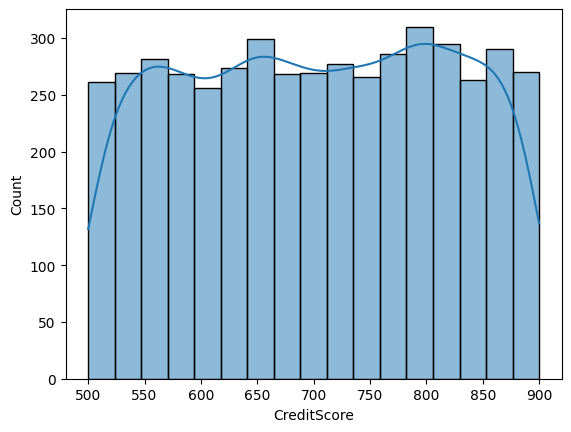

In [116]:
sns.histplot(df_cleaning['CreditScore'], kde=True)

Através da análise gráfica a distribuição aparenta ser uniforme. Irei confirmar isso aplicando um normal test que testa hipótese nula $H_0$ de que a amostra é proveniente de uma distribuição normal. Para o teste será utilizado um nível de significancia de 5%.

H0: A amostra é proveniente de uma normal


H1: A amostra não proveniente de uma normal

In [119]:
stat_test, pvalor = normaltest(df_cleaning['CreditScore'])

if pvalor < 0.05:
    print('Rejeitar H0: A variável não se trata de uma normal')
else:
    print('Não Rejeitar H0: A variável se trata de uma normal')

Rejeitar H0: A variável não se trata de uma normal


Como foi confirmado que a variável não se trata de uma normal seguirei com a utilização do teste de Mann-Whitney. Ele irá testar 

# Modelagem 
*** 

Tópico destinado para estimação de um modelo de regressão com objetivo de entender a relação entre as variáveis. 